In [1]:
import torch
from torch import nn
import torch.optim as optim
import pickle

import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [4]:
train_fh = open('C:\\Users\\809210\\Downloads\\lego-train.pickle', 'rb')
test_fh = open('C:\\Users\\809210\\Downloads\\lego-test.pickle', 'rb')

train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

In [5]:
train_data_X = [x[0] for x in train_data]
train_data_y = [y[1] for y in train_data]
test_data_X = [x[0] for x in test_data]
test_data_y = [y[1] for y in test_data]


def get_dataset(X, y):
    tensor_x = torch.Tensor(X)
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x, tensor_y)
    return dataset


train_dataset = get_dataset(train_data_X, train_data_y)
test_dataset = get_dataset(test_data_X, test_data_y)

C:\Users\809210\AppData\Local\Temp\ipykernel_13976\3594128272.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  tensor_x = torch.Tensor(X)


In [6]:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']

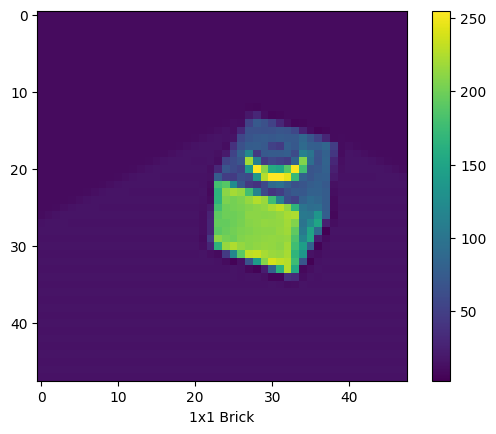

In [7]:
train_dataloader = DataLoader(train_dataset)
images_data, label_data = next(iter(train_dataloader))
plt.figure()
plt.imshow(images_data[0].numpy())
plt.colorbar()
plt.xlabel(class_names[label_data])
plt.show()

# NN

In [8]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def build_NN():
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(48*48, 576),
        nn.Sigmoid(),
        nn.Linear(576, 144),
        nn.Sigmoid(),
        nn.Linear(144, 36),
        nn.Sigmoid(),
        nn.Linear(36, 10)
    )

    net.apply(init_weights)

    return net

In [9]:
def train(net, train_loader, device, num_epochs, learning_rate):
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    loss_function = nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0

            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                inputs = inputs.permute(0, 3, 1, 2).to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                loss.backward()
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total

                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct
            acc = correct/total

            acc_history.append(acc)

        pbar.close()

    return acc_history

In [10]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

In [11]:
BATCH_SIZE = 24
EPOCHS = 30
LR = 0.01

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [12]:
net = build_NN()

In [13]:
hist = train(net, train_dataloader, device, EPOCHS, LR)

Epoch: 29, Batch: 18, Loss: 9.92, Acc: 0.89: 100%|███████████████████████████████████| 570/570 [00:24<00:00, 23.41it/s]


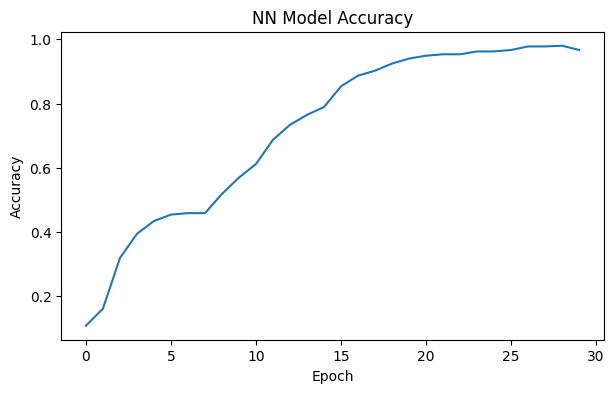

In [14]:
print_history(hist, "NN Model Accuracy")

# Lenet

In [15]:
def init_weights_2(m):
    if type(m) is nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    if type(m) is nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
# хуже, чем инициализировать только линейный слой?


def build_lenet():
    net = nn.Sequential(
        # Input: 48x48

        nn.Conv2d(1, 6, 5, padding=(2, 2)),  # out: 48x48x6
        nn.ReLU(),

        nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),  # out: 24x24x6
        nn.ReLU(),

        nn.Conv2d(6, 16, 5),  # out: 20x20x16
        nn.ReLU(),

        nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)),  # out: 10x10x16

        nn.Flatten(),

        nn.Linear(10*10*16, 400),
        nn.ReLU(),
        nn.Linear(400, 100),
        nn.ReLU(),
        nn.Linear(100, 40),
        nn.ReLU(),
        nn.Linear(40, 10),
    )

    net.apply(init_weights_2)
    return net

In [16]:
lenet = build_lenet()

In [17]:
BATCH_SIZE = 24
EPOCHS = 20
LR = 0.001

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

hist_lenet = train(lenet, train_dataloader, device, EPOCHS, LR)

Epoch: 19, Batch: 18, Loss: 0.09, Acc: 1.00: 100%|███████████████████████████████████| 380/380 [00:21<00:00, 18.01it/s]


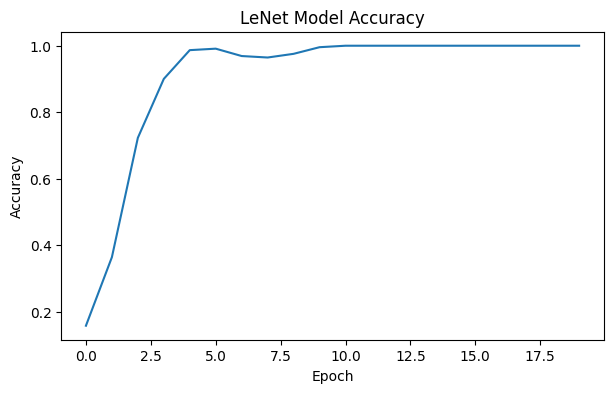

In [18]:
print_history(hist_lenet, "LeNet Model Accuracy")

# Alexnet

In [19]:
def build_alexnet():
    net = nn.Sequential(
        # Input: 48x48

        nn.Conv2d(1, 24, 4, padding=(2, 2)),  # out: 48x48x24
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)),  # out: 23x23x24
        nn.Conv2d(24, 128, 5, padding=(2, 2)),  # out: 23x23x128
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)),  # out: 11x11x128
        nn.Conv2d(128, 256, 3, padding=(1, 1)),  # out: 11x11x256
        nn.ReLU(),

        nn.Conv2d(256, 256, 3, padding=(1, 1)),  # out: 11x11x256
        nn.ReLU(),

        nn.Conv2d(256, 128, 3, padding=(1, 1)),  # out: 11x11x128
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)),  # out: 5x5x128

        nn.Flatten(),

        nn.Linear(5*5*128, 1024),
        nn.ReLU(),
        nn.Dropout(p=0.33),

        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Dropout(p=0.33),

        nn.Linear(256, 10),
    )

    net.apply(init_weights_2)
    return net

In [20]:
alexnet = build_alexnet()

In [21]:
BATCH_SIZE = 20
EPOCHS = 20
LR = 0.001

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [22]:
hist_alexnet = train(alexnet, train_dataloader, device, EPOCHS, LR)

Epoch: 19, Batch: 22, Loss: 2.62, Acc: 1.00: 100%|███████████████████████████████████| 460/460 [05:35<00:00,  1.37it/s]


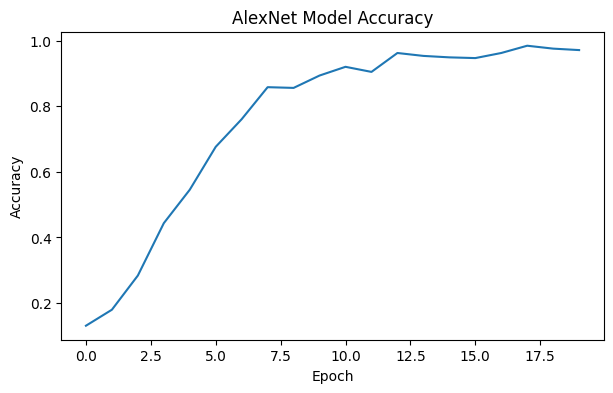

In [23]:
print_history(hist_alexnet, "AlexNet Model Accuracy")

# Accuracy

In [24]:
def evaluate_acc(net, test_loader, device):

    total = 0
    correct = 0

    for batch_num, (inputs, labels) in enumerate(test_loader):
        # Possibly copy inputs and labels to the GPU
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = correct/total
    return acc

In [25]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [26]:
net_acc = evaluate_acc(net, test_dataloader, device)
lenet_acc = evaluate_acc(lenet, test_dataloader, device)
alexnet_acc = evaluate_acc(alexnet, test_dataloader, device)

print(f"Test Accuracy (NN): {net_acc:.2}")
print(f"Test Accuracy (LeNet): {lenet_acc:.2}")
print(f"Test Accuracy (AlexNet): {alexnet_acc:.2}")

Test Accuracy (NN): 0.98
Test Accuracy (LeNet): 1.0
Test Accuracy (AlexNet): 0.99


In [27]:
def show_random(net, dataloader):
    def get_prediction(net, input):
        input = input.permute(2, 0, 1).to(device)
        outputs = net(input)
        _, predicted = outputs.max(1)
        return predicted

    images_data, original_label = next(iter(dataloader))
    images_data = images_data[0]
    original_label = original_label[0]

    predicted_label = get_prediction(net, images_data)
    print('original_label ', original_label)
    print('predicted_label ', predicted_label)
    if original_label == predicted_label:
        color = 'green'
    else:
        color = 'red'

    plt.figure()
    plt.imshow(images_data.numpy())
    plt.colorbar()

    plt.xlabel(class_names[predicted_label], color=color)
    plt.show()

original_label  tensor(4)
predicted_label  tensor([4])


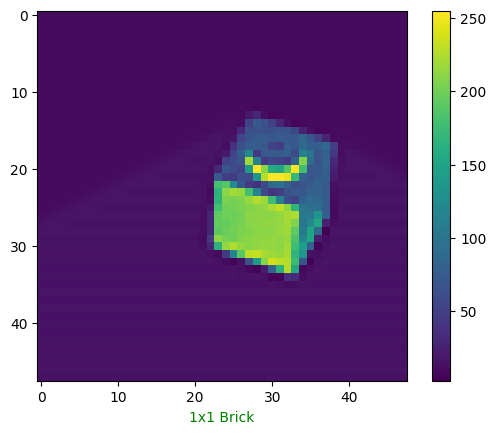

In [28]:
show_random(net, test_dataloader)
